# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-6
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.0989
Epoch 1/200, Iteration 2/25, Loss: 0.1642
Epoch 1/200, Iteration 3/25, Loss: 0.1367
Epoch 1/200, Iteration 4/25, Loss: 0.1192
Epoch 1/200, Iteration 5/25, Loss: 0.1149
Epoch 1/200, Iteration 6/25, Loss: 0.1292
Epoch 1/200, Iteration 7/25, Loss: 0.1375
Epoch 1/200, Iteration 8/25, Loss: 0.1098
Epoch 1/200, Iteration 9/25, Loss: 0.1004
Epoch 1/200, Iteration 10/25, Loss: 0.1169
Epoch 1/200, Iteration 11/25, Loss: 0.1207
Epoch 1/200, Iteration 12/25, Loss: 0.1343
Epoch 1/200, Iteration 13/25, Loss: 0.1240
Epoch 1/200, Iteration 14/25, Loss: 0.1422
Epoch 1/200, Iteration 15/25, Loss: 0.1071
Epoch 1/200, Iteration 16/25, Loss: 0.1267
Epoch 1/200, Iteration 17/25, Loss: 0.1253
Epoch 1/200, Iteration 18/25, Loss: 0.1184
Epoch 1/200, Iteration 19/25, Loss: 0.1138
Epoch 1/200, Iteration 20/25, Loss: 0.1289
Epoch 1/200, Iteration 21/25, Loss: 0.1473
Epoch 1/200, Iteration 22/25, Loss: 0.1302
Epoch 1/200, Iteration 23/25, Loss: 0.1297
Epoch 1/200, Iterati

Epoch 8/200, Iteration 8/25, Loss: 0.0857
Epoch 8/200, Iteration 9/25, Loss: 0.0662
Epoch 8/200, Iteration 10/25, Loss: 0.0718
Epoch 8/200, Iteration 11/25, Loss: 0.1157
Epoch 8/200, Iteration 12/25, Loss: 0.0948
Epoch 8/200, Iteration 13/25, Loss: 0.0851
Epoch 8/200, Iteration 14/25, Loss: 0.0885
Epoch 8/200, Iteration 15/25, Loss: 0.0753
Epoch 8/200, Iteration 16/25, Loss: 0.0905
Epoch 8/200, Iteration 17/25, Loss: 0.0813
Epoch 8/200, Iteration 18/25, Loss: 0.0812
Epoch 8/200, Iteration 19/25, Loss: 0.0894
Epoch 8/200, Iteration 20/25, Loss: 0.0896
Epoch 8/200, Iteration 21/25, Loss: 0.0517
Epoch 8/200, Iteration 22/25, Loss: 0.0556
Epoch 8/200, Iteration 23/25, Loss: 0.0853
Epoch 8/200, Iteration 24/25, Loss: 0.1112
Epoch 8/200, Iteration 25/25, Loss: 0.0979
Train Error: 
 Accuracy: 29.25%, Avg loss: 0.082988, MRE: 3.499262 

Test Error: 
 Accuracy: 29.0%, Avg loss: 0.090695, MRE: 10.649920 

Epoch 9/200, Iteration 1/25, Loss: 0.0757
Epoch 9/200, Iteration 2/25, Loss: 0.0978
Epoch 9

Epoch 15/200, Iteration 2/25, Loss: 0.0619
Epoch 15/200, Iteration 3/25, Loss: 0.0401
Epoch 15/200, Iteration 4/25, Loss: 0.0529
Epoch 15/200, Iteration 5/25, Loss: 0.0607
Epoch 15/200, Iteration 6/25, Loss: 0.0546
Epoch 15/200, Iteration 7/25, Loss: 0.0448
Epoch 15/200, Iteration 8/25, Loss: 0.0744
Epoch 15/200, Iteration 9/25, Loss: 0.0688
Epoch 15/200, Iteration 10/25, Loss: 0.0805
Epoch 15/200, Iteration 11/25, Loss: 0.0432
Epoch 15/200, Iteration 12/25, Loss: 0.0446
Epoch 15/200, Iteration 13/25, Loss: 0.0542
Epoch 15/200, Iteration 14/25, Loss: 0.0400
Epoch 15/200, Iteration 15/25, Loss: 0.0539
Epoch 15/200, Iteration 16/25, Loss: 0.0406
Epoch 15/200, Iteration 17/25, Loss: 0.0557
Epoch 15/200, Iteration 18/25, Loss: 0.0536
Epoch 15/200, Iteration 19/25, Loss: 0.0370
Epoch 15/200, Iteration 20/25, Loss: 0.0497
Epoch 15/200, Iteration 21/25, Loss: 0.0275
Epoch 15/200, Iteration 22/25, Loss: 0.0544
Epoch 15/200, Iteration 23/25, Loss: 0.0457
Epoch 15/200, Iteration 24/25, Loss: 0.0

Epoch 22/200, Iteration 8/25, Loss: 0.0331
Epoch 22/200, Iteration 9/25, Loss: 0.0316
Epoch 22/200, Iteration 10/25, Loss: 0.0242
Epoch 22/200, Iteration 11/25, Loss: 0.0242
Epoch 22/200, Iteration 12/25, Loss: 0.0202
Epoch 22/200, Iteration 13/25, Loss: 0.0472
Epoch 22/200, Iteration 14/25, Loss: 0.0209
Epoch 22/200, Iteration 15/25, Loss: 0.0227
Epoch 22/200, Iteration 16/25, Loss: 0.0359
Epoch 22/200, Iteration 17/25, Loss: 0.0281
Epoch 22/200, Iteration 18/25, Loss: 0.0168
Epoch 22/200, Iteration 19/25, Loss: 0.0489
Epoch 22/200, Iteration 20/25, Loss: 0.0226
Epoch 22/200, Iteration 21/25, Loss: 0.0196
Epoch 22/200, Iteration 22/25, Loss: 0.0179
Epoch 22/200, Iteration 23/25, Loss: 0.0284
Epoch 22/200, Iteration 24/25, Loss: 0.0245
Epoch 22/200, Iteration 25/25, Loss: 0.0417
Train Error: 
 Accuracy: 50.12%, Avg loss: 0.021008, MRE: 1.194721 

Test Error: 
 Accuracy: 47.0%, Avg loss: 0.023155, MRE: 2.532424 

Epoch 23/200, Iteration 1/25, Loss: 0.0331
Epoch 23/200, Iteration 2/25, L

Epoch 29/200, Iteration 14/25, Loss: 0.0209
Epoch 29/200, Iteration 15/25, Loss: 0.0186
Epoch 29/200, Iteration 16/25, Loss: 0.0454
Epoch 29/200, Iteration 17/25, Loss: 0.0152
Epoch 29/200, Iteration 18/25, Loss: 0.0204
Epoch 29/200, Iteration 19/25, Loss: 0.0295
Epoch 29/200, Iteration 20/25, Loss: 0.0331
Epoch 29/200, Iteration 21/25, Loss: 0.0157
Epoch 29/200, Iteration 22/25, Loss: 0.0241
Epoch 29/200, Iteration 23/25, Loss: 0.0218
Epoch 29/200, Iteration 24/25, Loss: 0.0301
Epoch 29/200, Iteration 25/25, Loss: 0.0206
Train Error: 
 Accuracy: 67.25%, Avg loss: 0.015577, MRE: 1.172788 

Test Error: 
 Accuracy: 63.5%, Avg loss: 0.017208, MRE: 1.473327 

Epoch 30/200, Iteration 1/25, Loss: 0.0181
Epoch 30/200, Iteration 2/25, Loss: 0.0621
Epoch 30/200, Iteration 3/25, Loss: 0.0174
Epoch 30/200, Iteration 4/25, Loss: 0.0197
Epoch 30/200, Iteration 5/25, Loss: 0.0285
Epoch 30/200, Iteration 6/25, Loss: 0.0278
Epoch 30/200, Iteration 7/25, Loss: 0.0148
Epoch 30/200, Iteration 8/25, Loss:

Epoch 36/200, Iteration 11/25, Loss: 0.0139
Epoch 36/200, Iteration 12/25, Loss: 0.0217
Epoch 36/200, Iteration 13/25, Loss: 0.0175
Epoch 36/200, Iteration 14/25, Loss: 0.0160
Epoch 36/200, Iteration 15/25, Loss: 0.0148
Epoch 36/200, Iteration 16/25, Loss: 0.0166
Epoch 36/200, Iteration 17/25, Loss: 0.0169
Epoch 36/200, Iteration 18/25, Loss: 0.0368
Epoch 36/200, Iteration 19/25, Loss: 0.0224
Epoch 36/200, Iteration 20/25, Loss: 0.0164
Epoch 36/200, Iteration 21/25, Loss: 0.0149
Epoch 36/200, Iteration 22/25, Loss: 0.0313
Epoch 36/200, Iteration 23/25, Loss: 0.0314
Epoch 36/200, Iteration 24/25, Loss: 0.0177
Epoch 36/200, Iteration 25/25, Loss: 0.0183
Train Error: 
 Accuracy: 76.5%, Avg loss: 0.015509, MRE: 1.200246 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.016451, MRE: 1.253986 

Epoch 37/200, Iteration 1/25, Loss: 0.0162
Epoch 37/200, Iteration 2/25, Loss: 0.0305
Epoch 37/200, Iteration 3/25, Loss: 0.0259
Epoch 37/200, Iteration 4/25, Loss: 0.0244
Epoch 37/200, Iteration 5/25, Los

Train Error: 
 Accuracy: 70.25%, Avg loss: 0.015012, MRE: 1.188941 

Test Error: 
 Accuracy: 67.0%, Avg loss: 0.016337, MRE: 1.529912 

Epoch 44/200, Iteration 1/25, Loss: 0.0230
Epoch 44/200, Iteration 2/25, Loss: 0.0205
Epoch 44/200, Iteration 3/25, Loss: 0.0216
Epoch 44/200, Iteration 4/25, Loss: 0.0245
Epoch 44/200, Iteration 5/25, Loss: 0.0201
Epoch 44/200, Iteration 6/25, Loss: 0.0137
Epoch 44/200, Iteration 7/25, Loss: 0.0146
Epoch 44/200, Iteration 8/25, Loss: 0.0099
Epoch 44/200, Iteration 9/25, Loss: 0.0182
Epoch 44/200, Iteration 10/25, Loss: 0.0167
Epoch 44/200, Iteration 11/25, Loss: 0.0247
Epoch 44/200, Iteration 12/25, Loss: 0.0217
Epoch 44/200, Iteration 13/25, Loss: 0.0169
Epoch 44/200, Iteration 14/25, Loss: 0.0156
Epoch 44/200, Iteration 15/25, Loss: 0.0119
Epoch 44/200, Iteration 16/25, Loss: 0.0193
Epoch 44/200, Iteration 17/25, Loss: 0.0259
Epoch 44/200, Iteration 18/25, Loss: 0.0281
Epoch 44/200, Iteration 19/25, Loss: 0.0301
Epoch 44/200, Iteration 20/25, Loss: 

Epoch 50/200, Iteration 19/25, Loss: 0.0152
Epoch 50/200, Iteration 20/25, Loss: 0.0166
Epoch 50/200, Iteration 21/25, Loss: 0.0224
Epoch 50/200, Iteration 22/25, Loss: 0.0233
Epoch 50/200, Iteration 23/25, Loss: 0.0216
Epoch 50/200, Iteration 24/25, Loss: 0.0302
Epoch 50/200, Iteration 25/25, Loss: 0.0239
Train Error: 
 Accuracy: 74.62%, Avg loss: 0.014775, MRE: 1.146289 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.015941, MRE: 1.352700 

Epoch 51/200, Iteration 1/25, Loss: 0.0157
Epoch 51/200, Iteration 2/25, Loss: 0.0202
Epoch 51/200, Iteration 3/25, Loss: 0.0166
Epoch 51/200, Iteration 4/25, Loss: 0.0153
Epoch 51/200, Iteration 5/25, Loss: 0.0357
Epoch 51/200, Iteration 6/25, Loss: 0.0122
Epoch 51/200, Iteration 7/25, Loss: 0.0248
Epoch 51/200, Iteration 8/25, Loss: 0.0213
Epoch 51/200, Iteration 9/25, Loss: 0.0224
Epoch 51/200, Iteration 10/25, Loss: 0.0262
Epoch 51/200, Iteration 11/25, Loss: 0.0170
Epoch 51/200, Iteration 12/25, Loss: 0.0235
Epoch 51/200, Iteration 13/25, Loss: 

Epoch 58/200, Iteration 6/25, Loss: 0.0155
Epoch 58/200, Iteration 7/25, Loss: 0.0100
Epoch 58/200, Iteration 8/25, Loss: 0.0187
Epoch 58/200, Iteration 9/25, Loss: 0.0152
Epoch 58/200, Iteration 10/25, Loss: 0.0209
Epoch 58/200, Iteration 11/25, Loss: 0.0193
Epoch 58/200, Iteration 12/25, Loss: 0.0146
Epoch 58/200, Iteration 13/25, Loss: 0.0410
Epoch 58/200, Iteration 14/25, Loss: 0.0261
Epoch 58/200, Iteration 15/25, Loss: 0.0159
Epoch 58/200, Iteration 16/25, Loss: 0.0270
Epoch 58/200, Iteration 17/25, Loss: 0.0134
Epoch 58/200, Iteration 18/25, Loss: 0.0328
Epoch 58/200, Iteration 19/25, Loss: 0.0170
Epoch 58/200, Iteration 20/25, Loss: 0.0159
Epoch 58/200, Iteration 21/25, Loss: 0.0152
Epoch 58/200, Iteration 22/25, Loss: 0.0142
Epoch 58/200, Iteration 23/25, Loss: 0.0150
Epoch 58/200, Iteration 24/25, Loss: 0.0236
Epoch 58/200, Iteration 25/25, Loss: 0.0223
Train Error: 
 Accuracy: 75.5%, Avg loss: 0.014816, MRE: 1.155940 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.015912, MRE: 

Train Error: 
 Accuracy: 72.88%, Avg loss: 0.014585, MRE: 1.161911 

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.015607, MRE: 1.325094 

Epoch 65/200, Iteration 1/25, Loss: 0.0256
Epoch 65/200, Iteration 2/25, Loss: 0.0179
Epoch 65/200, Iteration 3/25, Loss: 0.0149
Epoch 65/200, Iteration 4/25, Loss: 0.0178
Epoch 65/200, Iteration 5/25, Loss: 0.0131
Epoch 65/200, Iteration 6/25, Loss: 0.0171
Epoch 65/200, Iteration 7/25, Loss: 0.0305
Epoch 65/200, Iteration 8/25, Loss: 0.0152
Epoch 65/200, Iteration 9/25, Loss: 0.0194
Epoch 65/200, Iteration 10/25, Loss: 0.0153
Epoch 65/200, Iteration 11/25, Loss: 0.0125
Epoch 65/200, Iteration 12/25, Loss: 0.0271
Epoch 65/200, Iteration 13/25, Loss: 0.0234
Epoch 65/200, Iteration 14/25, Loss: 0.0177
Epoch 65/200, Iteration 15/25, Loss: 0.0191
Epoch 65/200, Iteration 16/25, Loss: 0.0262
Epoch 65/200, Iteration 17/25, Loss: 0.0134
Epoch 65/200, Iteration 18/25, Loss: 0.0217
Epoch 65/200, Iteration 19/25, Loss: 0.0272
Epoch 65/200, Iteration 20/25, Loss: 

Epoch 72/200, Iteration 20/25, Loss: 0.0159
Epoch 72/200, Iteration 21/25, Loss: 0.0147
Epoch 72/200, Iteration 22/25, Loss: 0.0197
Epoch 72/200, Iteration 23/25, Loss: 0.0135
Epoch 72/200, Iteration 24/25, Loss: 0.0211
Epoch 72/200, Iteration 25/25, Loss: 0.0234
Train Error: 
 Accuracy: 74.75%, Avg loss: 0.014445, MRE: 1.153845 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.015504, MRE: 1.319755 

Epoch 73/200, Iteration 1/25, Loss: 0.0232
Epoch 73/200, Iteration 2/25, Loss: 0.0276
Epoch 73/200, Iteration 3/25, Loss: 0.0168
Epoch 73/200, Iteration 4/25, Loss: 0.0249
Epoch 73/200, Iteration 5/25, Loss: 0.0229
Epoch 73/200, Iteration 6/25, Loss: 0.0150
Epoch 73/200, Iteration 7/25, Loss: 0.0326
Epoch 73/200, Iteration 8/25, Loss: 0.0378
Epoch 73/200, Iteration 9/25, Loss: 0.0182
Epoch 73/200, Iteration 10/25, Loss: 0.0137
Epoch 73/200, Iteration 11/25, Loss: 0.0221
Epoch 73/200, Iteration 12/25, Loss: 0.0144
Epoch 73/200, Iteration 13/25, Loss: 0.0121
Epoch 73/200, Iteration 14/25, Loss: 

Epoch 80/200, Iteration 14/25, Loss: 0.0228
Epoch 80/200, Iteration 15/25, Loss: 0.0152
Epoch 80/200, Iteration 16/25, Loss: 0.0122
Epoch 80/200, Iteration 17/25, Loss: 0.0296
Epoch 80/200, Iteration 18/25, Loss: 0.0105
Epoch 80/200, Iteration 19/25, Loss: 0.0265
Epoch 80/200, Iteration 20/25, Loss: 0.0203
Epoch 80/200, Iteration 21/25, Loss: 0.0222
Epoch 80/200, Iteration 22/25, Loss: 0.0186
Epoch 80/200, Iteration 23/25, Loss: 0.0286
Epoch 80/200, Iteration 24/25, Loss: 0.0265
Epoch 80/200, Iteration 25/25, Loss: 0.0168
Train Error: 
 Accuracy: 64.12%, Avg loss: 0.014299, MRE: 1.116488 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.015746, MRE: 1.186165 

Epoch 81/200, Iteration 1/25, Loss: 0.0147
Epoch 81/200, Iteration 2/25, Loss: 0.0166
Epoch 81/200, Iteration 3/25, Loss: 0.0149
Epoch 81/200, Iteration 4/25, Loss: 0.0239
Epoch 81/200, Iteration 5/25, Loss: 0.0188
Epoch 81/200, Iteration 6/25, Loss: 0.0270
Epoch 81/200, Iteration 7/25, Loss: 0.0155
Epoch 81/200, Iteration 8/25, Loss:

Train Error: 
 Accuracy: 72.12%, Avg loss: 0.013846, MRE: 1.023018 

Test Error: 
 Accuracy: 68.0%, Avg loss: 0.015381, MRE: 1.469732 

Epoch 88/200, Iteration 1/25, Loss: 0.0190
Epoch 88/200, Iteration 2/25, Loss: 0.0221
Epoch 88/200, Iteration 3/25, Loss: 0.0146
Epoch 88/200, Iteration 4/25, Loss: 0.0154
Epoch 88/200, Iteration 5/25, Loss: 0.0176
Epoch 88/200, Iteration 6/25, Loss: 0.0176
Epoch 88/200, Iteration 7/25, Loss: 0.0140
Epoch 88/200, Iteration 8/25, Loss: 0.0420
Epoch 88/200, Iteration 9/25, Loss: 0.0136
Epoch 88/200, Iteration 10/25, Loss: 0.0137
Epoch 88/200, Iteration 11/25, Loss: 0.0222
Epoch 88/200, Iteration 12/25, Loss: 0.0251
Epoch 88/200, Iteration 13/25, Loss: 0.0280
Epoch 88/200, Iteration 14/25, Loss: 0.0151
Epoch 88/200, Iteration 15/25, Loss: 0.0212
Epoch 88/200, Iteration 16/25, Loss: 0.0325
Epoch 88/200, Iteration 17/25, Loss: 0.0153
Epoch 88/200, Iteration 18/25, Loss: 0.0185
Epoch 88/200, Iteration 19/25, Loss: 0.0135
Epoch 88/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 80.5%, Avg loss: 0.014002, MRE: 1.015516 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.015028, MRE: 1.441958 

Epoch 95/200, Iteration 1/25, Loss: 0.0170
Epoch 95/200, Iteration 2/25, Loss: 0.0219
Epoch 95/200, Iteration 3/25, Loss: 0.0175
Epoch 95/200, Iteration 4/25, Loss: 0.0228
Epoch 95/200, Iteration 5/25, Loss: 0.0220
Epoch 95/200, Iteration 6/25, Loss: 0.0185
Epoch 95/200, Iteration 7/25, Loss: 0.0239
Epoch 95/200, Iteration 8/25, Loss: 0.0400
Epoch 95/200, Iteration 9/25, Loss: 0.0105
Epoch 95/200, Iteration 10/25, Loss: 0.0247
Epoch 95/200, Iteration 11/25, Loss: 0.0204
Epoch 95/200, Iteration 12/25, Loss: 0.0237
Epoch 95/200, Iteration 13/25, Loss: 0.0155
Epoch 95/200, Iteration 14/25, Loss: 0.0207
Epoch 95/200, Iteration 15/25, Loss: 0.0145
Epoch 95/200, Iteration 16/25, Loss: 0.0357
Epoch 95/200, Iteration 17/25, Loss: 0.0207
Epoch 95/200, Iteration 18/25, Loss: 0.0127
Epoch 95/200, Iteration 19/25, Loss: 0.0219
Epoch 95/200, Iteration 20/25, Loss: 0

Epoch 101/200, Iteration 21/25, Loss: 0.0186
Epoch 101/200, Iteration 22/25, Loss: 0.0218
Epoch 101/200, Iteration 23/25, Loss: 0.0179
Epoch 101/200, Iteration 24/25, Loss: 0.0197
Epoch 101/200, Iteration 25/25, Loss: 0.0159
Train Error: 
 Accuracy: 82.12%, Avg loss: 0.014050, MRE: 1.055904 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.014790, MRE: 1.035298 

Epoch 102/200, Iteration 1/25, Loss: 0.0136
Epoch 102/200, Iteration 2/25, Loss: 0.0186
Epoch 102/200, Iteration 3/25, Loss: 0.0264
Epoch 102/200, Iteration 4/25, Loss: 0.0118
Epoch 102/200, Iteration 5/25, Loss: 0.0156
Epoch 102/200, Iteration 6/25, Loss: 0.0162
Epoch 102/200, Iteration 7/25, Loss: 0.0177
Epoch 102/200, Iteration 8/25, Loss: 0.0141
Epoch 102/200, Iteration 9/25, Loss: 0.0182
Epoch 102/200, Iteration 10/25, Loss: 0.0301
Epoch 102/200, Iteration 11/25, Loss: 0.0154
Epoch 102/200, Iteration 12/25, Loss: 0.0153
Epoch 102/200, Iteration 13/25, Loss: 0.0126
Epoch 102/200, Iteration 14/25, Loss: 0.0181
Epoch 102/200, Ite

Epoch 109/200, Iteration 16/25, Loss: 0.0150
Epoch 109/200, Iteration 17/25, Loss: 0.0124
Epoch 109/200, Iteration 18/25, Loss: 0.0145
Epoch 109/200, Iteration 19/25, Loss: 0.0139
Epoch 109/200, Iteration 20/25, Loss: 0.0145
Epoch 109/200, Iteration 21/25, Loss: 0.0151
Epoch 109/200, Iteration 22/25, Loss: 0.0344
Epoch 109/200, Iteration 23/25, Loss: 0.0118
Epoch 109/200, Iteration 24/25, Loss: 0.0103
Epoch 109/200, Iteration 25/25, Loss: 0.0194
Train Error: 
 Accuracy: 80.25%, Avg loss: 0.013658, MRE: 1.012733 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.014655, MRE: 1.008053 

Epoch 110/200, Iteration 1/25, Loss: 0.0196
Epoch 110/200, Iteration 2/25, Loss: 0.0143
Epoch 110/200, Iteration 3/25, Loss: 0.0266
Epoch 110/200, Iteration 4/25, Loss: 0.0146
Epoch 110/200, Iteration 5/25, Loss: 0.0173
Epoch 110/200, Iteration 6/25, Loss: 0.0323
Epoch 110/200, Iteration 7/25, Loss: 0.0234
Epoch 110/200, Iteration 8/25, Loss: 0.0444
Epoch 110/200, Iteration 9/25, Loss: 0.0346
Epoch 110/200, Ite

Epoch 116/200, Iteration 15/25, Loss: 0.0180
Epoch 116/200, Iteration 16/25, Loss: 0.0157
Epoch 116/200, Iteration 17/25, Loss: 0.0198
Epoch 116/200, Iteration 18/25, Loss: 0.0138
Epoch 116/200, Iteration 19/25, Loss: 0.0217
Epoch 116/200, Iteration 20/25, Loss: 0.0123
Epoch 116/200, Iteration 21/25, Loss: 0.0155
Epoch 116/200, Iteration 22/25, Loss: 0.0341
Epoch 116/200, Iteration 23/25, Loss: 0.0227
Epoch 116/200, Iteration 24/25, Loss: 0.0139
Epoch 116/200, Iteration 25/25, Loss: 0.0150
Train Error: 
 Accuracy: 78.62%, Avg loss: 0.013291, MRE: 0.989904 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.014477, MRE: 1.304953 

Epoch 117/200, Iteration 1/25, Loss: 0.0246
Epoch 117/200, Iteration 2/25, Loss: 0.0197
Epoch 117/200, Iteration 3/25, Loss: 0.0138
Epoch 117/200, Iteration 4/25, Loss: 0.0181
Epoch 117/200, Iteration 5/25, Loss: 0.0191
Epoch 117/200, Iteration 6/25, Loss: 0.0211
Epoch 117/200, Iteration 7/25, Loss: 0.0279
Epoch 117/200, Iteration 8/25, Loss: 0.0173
Epoch 117/200, It

Epoch 123/200, Iteration 21/25, Loss: 0.0230
Epoch 123/200, Iteration 22/25, Loss: 0.0239
Epoch 123/200, Iteration 23/25, Loss: 0.0170
Epoch 123/200, Iteration 24/25, Loss: 0.0263
Epoch 123/200, Iteration 25/25, Loss: 0.0239
Train Error: 
 Accuracy: 77.62%, Avg loss: 0.013105, MRE: 0.952672 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.014445, MRE: 1.292312 

Epoch 124/200, Iteration 1/25, Loss: 0.0138
Epoch 124/200, Iteration 2/25, Loss: 0.0164
Epoch 124/200, Iteration 3/25, Loss: 0.0167
Epoch 124/200, Iteration 4/25, Loss: 0.0212
Epoch 124/200, Iteration 5/25, Loss: 0.0446
Epoch 124/200, Iteration 6/25, Loss: 0.0152
Epoch 124/200, Iteration 7/25, Loss: 0.0164
Epoch 124/200, Iteration 8/25, Loss: 0.0145
Epoch 124/200, Iteration 9/25, Loss: 0.0161
Epoch 124/200, Iteration 10/25, Loss: 0.0131
Epoch 124/200, Iteration 11/25, Loss: 0.0125
Epoch 124/200, Iteration 12/25, Loss: 0.0140
Epoch 124/200, Iteration 13/25, Loss: 0.0156
Epoch 124/200, Iteration 14/25, Loss: 0.0388
Epoch 124/200, Ite

Epoch 130/200, Iteration 17/25, Loss: 0.0148
Epoch 130/200, Iteration 18/25, Loss: 0.0476
Epoch 130/200, Iteration 19/25, Loss: 0.0194
Epoch 130/200, Iteration 20/25, Loss: 0.0114
Epoch 130/200, Iteration 21/25, Loss: 0.0181
Epoch 130/200, Iteration 22/25, Loss: 0.0188
Epoch 130/200, Iteration 23/25, Loss: 0.0397
Epoch 130/200, Iteration 24/25, Loss: 0.0225
Epoch 130/200, Iteration 25/25, Loss: 0.0121
Train Error: 
 Accuracy: 73.75%, Avg loss: 0.013113, MRE: 1.053084 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.014128, MRE: 1.042325 

Epoch 131/200, Iteration 1/25, Loss: 0.0168
Epoch 131/200, Iteration 2/25, Loss: 0.0177
Epoch 131/200, Iteration 3/25, Loss: 0.0161
Epoch 131/200, Iteration 4/25, Loss: 0.0193
Epoch 131/200, Iteration 5/25, Loss: 0.0140
Epoch 131/200, Iteration 6/25, Loss: 0.0279
Epoch 131/200, Iteration 7/25, Loss: 0.0183
Epoch 131/200, Iteration 8/25, Loss: 0.0156
Epoch 131/200, Iteration 9/25, Loss: 0.0197
Epoch 131/200, Iteration 10/25, Loss: 0.0152
Epoch 131/200, Ite

Epoch 138/200, Iteration 20/25, Loss: 0.0216
Epoch 138/200, Iteration 21/25, Loss: 0.0147
Epoch 138/200, Iteration 22/25, Loss: 0.0196
Epoch 138/200, Iteration 23/25, Loss: 0.0143
Epoch 138/200, Iteration 24/25, Loss: 0.0199
Epoch 138/200, Iteration 25/25, Loss: 0.0300
Train Error: 
 Accuracy: 79.0%, Avg loss: 0.013153, MRE: 0.971576 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.014333, MRE: 1.196613 

Epoch 139/200, Iteration 1/25, Loss: 0.0133
Epoch 139/200, Iteration 2/25, Loss: 0.0210
Epoch 139/200, Iteration 3/25, Loss: 0.0180
Epoch 139/200, Iteration 4/25, Loss: 0.0310
Epoch 139/200, Iteration 5/25, Loss: 0.0157
Epoch 139/200, Iteration 6/25, Loss: 0.0179
Epoch 139/200, Iteration 7/25, Loss: 0.0167
Epoch 139/200, Iteration 8/25, Loss: 0.0378
Epoch 139/200, Iteration 9/25, Loss: 0.0146
Epoch 139/200, Iteration 10/25, Loss: 0.0175
Epoch 139/200, Iteration 11/25, Loss: 0.0154
Epoch 139/200, Iteration 12/25, Loss: 0.0111
Epoch 139/200, Iteration 13/25, Loss: 0.0318
Epoch 139/200, Iter

Epoch 146/200, Iteration 10/25, Loss: 0.0152
Epoch 146/200, Iteration 11/25, Loss: 0.0160
Epoch 146/200, Iteration 12/25, Loss: 0.0163
Epoch 146/200, Iteration 13/25, Loss: 0.0160
Epoch 146/200, Iteration 14/25, Loss: 0.0143
Epoch 146/200, Iteration 15/25, Loss: 0.0216
Epoch 146/200, Iteration 16/25, Loss: 0.0187
Epoch 146/200, Iteration 17/25, Loss: 0.0145
Epoch 146/200, Iteration 18/25, Loss: 0.0185
Epoch 146/200, Iteration 19/25, Loss: 0.0122
Epoch 146/200, Iteration 20/25, Loss: 0.0156
Epoch 146/200, Iteration 21/25, Loss: 0.0200
Epoch 146/200, Iteration 22/25, Loss: 0.0126
Epoch 146/200, Iteration 23/25, Loss: 0.0197
Epoch 146/200, Iteration 24/25, Loss: 0.0148
Epoch 146/200, Iteration 25/25, Loss: 0.0160
Train Error: 
 Accuracy: 73.62%, Avg loss: 0.012613, MRE: 0.975699 

Test Error: 
 Accuracy: 69.5%, Avg loss: 0.013827, MRE: 1.283793 

Epoch 147/200, Iteration 1/25, Loss: 0.0207
Epoch 147/200, Iteration 2/25, Loss: 0.0127
Epoch 147/200, Iteration 3/25, Loss: 0.0177
Epoch 147/20

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.013698, MRE: 1.212149 

Epoch 153/200, Iteration 1/25, Loss: 0.0110
Epoch 153/200, Iteration 2/25, Loss: 0.0278
Epoch 153/200, Iteration 3/25, Loss: 0.0169
Epoch 153/200, Iteration 4/25, Loss: 0.0277
Epoch 153/200, Iteration 5/25, Loss: 0.0182
Epoch 153/200, Iteration 6/25, Loss: 0.0145
Epoch 153/200, Iteration 7/25, Loss: 0.0220
Epoch 153/200, Iteration 8/25, Loss: 0.0160
Epoch 153/200, Iteration 9/25, Loss: 0.0126
Epoch 153/200, Iteration 10/25, Loss: 0.0293
Epoch 153/200, Iteration 11/25, Loss: 0.0256
Epoch 153/200, Iteration 12/25, Loss: 0.0182
Epoch 153/200, Iteration 13/25, Loss: 0.0428
Epoch 153/200, Iteration 14/25, Loss: 0.0155
Epoch 153/200, Iteration 15/25, Loss: 0.0224
Epoch 153/200, Iteration 16/25, Loss: 0.0201
Epoch 153/200, Iteration 17/25, Loss: 0.0180
Epoch 153/200, Iteration 18/25, Loss: 0.0173
Epoch 153/200, Iteration 19/25, Loss: 0.0188
Epoch 153/200, Iteration 20/25, Loss: 0.0225
Epoch 153/200, Iteration 21/25, Loss: 0.01

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.013401, MRE: 0.954306 

Epoch 160/200, Iteration 1/25, Loss: 0.0297
Epoch 160/200, Iteration 2/25, Loss: 0.0368
Epoch 160/200, Iteration 3/25, Loss: 0.0136
Epoch 160/200, Iteration 4/25, Loss: 0.0224
Epoch 160/200, Iteration 5/25, Loss: 0.0239
Epoch 160/200, Iteration 6/25, Loss: 0.0315
Epoch 160/200, Iteration 7/25, Loss: 0.0168
Epoch 160/200, Iteration 8/25, Loss: 0.0173
Epoch 160/200, Iteration 9/25, Loss: 0.0152
Epoch 160/200, Iteration 10/25, Loss: 0.0145
Epoch 160/200, Iteration 11/25, Loss: 0.0310
Epoch 160/200, Iteration 12/25, Loss: 0.0154
Epoch 160/200, Iteration 13/25, Loss: 0.0159
Epoch 160/200, Iteration 14/25, Loss: 0.0161
Epoch 160/200, Iteration 15/25, Loss: 0.0162
Epoch 160/200, Iteration 16/25, Loss: 0.0149
Epoch 160/200, Iteration 17/25, Loss: 0.0240
Epoch 160/200, Iteration 18/25, Loss: 0.0386
Epoch 160/200, Iteration 19/25, Loss: 0.0167
Epoch 160/200, Iteration 20/25, Loss: 0.0232
Epoch 160/200, Iteration 21/25, Loss: 0.03

Epoch 166/200, Iteration 20/25, Loss: 0.0210
Epoch 166/200, Iteration 21/25, Loss: 0.0136
Epoch 166/200, Iteration 22/25, Loss: 0.0179
Epoch 166/200, Iteration 23/25, Loss: 0.0161
Epoch 166/200, Iteration 24/25, Loss: 0.0174
Epoch 166/200, Iteration 25/25, Loss: 0.0185
Train Error: 
 Accuracy: 77.25%, Avg loss: 0.012414, MRE: 0.998434 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.013422, MRE: 1.057869 

Epoch 167/200, Iteration 1/25, Loss: 0.0248
Epoch 167/200, Iteration 2/25, Loss: 0.0321
Epoch 167/200, Iteration 3/25, Loss: 0.0137
Epoch 167/200, Iteration 4/25, Loss: 0.0126
Epoch 167/200, Iteration 5/25, Loss: 0.0285
Epoch 167/200, Iteration 6/25, Loss: 0.0132
Epoch 167/200, Iteration 7/25, Loss: 0.0168
Epoch 167/200, Iteration 8/25, Loss: 0.0116
Epoch 167/200, Iteration 9/25, Loss: 0.0206
Epoch 167/200, Iteration 10/25, Loss: 0.0190
Epoch 167/200, Iteration 11/25, Loss: 0.0221
Epoch 167/200, Iteration 12/25, Loss: 0.0169
Epoch 167/200, Iteration 13/25, Loss: 0.0234
Epoch 167/200, Ite

Epoch 173/200, Iteration 8/25, Loss: 0.0157
Epoch 173/200, Iteration 9/25, Loss: 0.0156
Epoch 173/200, Iteration 10/25, Loss: 0.0190
Epoch 173/200, Iteration 11/25, Loss: 0.0193
Epoch 173/200, Iteration 12/25, Loss: 0.0180
Epoch 173/200, Iteration 13/25, Loss: 0.0333
Epoch 173/200, Iteration 14/25, Loss: 0.0216
Epoch 173/200, Iteration 15/25, Loss: 0.0191
Epoch 173/200, Iteration 16/25, Loss: 0.0194
Epoch 173/200, Iteration 17/25, Loss: 0.0126
Epoch 173/200, Iteration 18/25, Loss: 0.0292
Epoch 173/200, Iteration 19/25, Loss: 0.0234
Epoch 173/200, Iteration 20/25, Loss: 0.0153
Epoch 173/200, Iteration 21/25, Loss: 0.0114
Epoch 173/200, Iteration 22/25, Loss: 0.0159
Epoch 173/200, Iteration 23/25, Loss: 0.0191
Epoch 173/200, Iteration 24/25, Loss: 0.0150
Epoch 173/200, Iteration 25/25, Loss: 0.0158
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.012361, MRE: 0.961886 

Test Error: 
 Accuracy: 67.5%, Avg loss: 0.013746, MRE: 1.144940 

Epoch 174/200, Iteration 1/25, Loss: 0.0169
Epoch 174/200

Epoch 180/200, Iteration 6/25, Loss: 0.0154
Epoch 180/200, Iteration 7/25, Loss: 0.0193
Epoch 180/200, Iteration 8/25, Loss: 0.0257
Epoch 180/200, Iteration 9/25, Loss: 0.0135
Epoch 180/200, Iteration 10/25, Loss: 0.0122
Epoch 180/200, Iteration 11/25, Loss: 0.0118
Epoch 180/200, Iteration 12/25, Loss: 0.0194
Epoch 180/200, Iteration 13/25, Loss: 0.0208
Epoch 180/200, Iteration 14/25, Loss: 0.0185
Epoch 180/200, Iteration 15/25, Loss: 0.0109
Epoch 180/200, Iteration 16/25, Loss: 0.0183
Epoch 180/200, Iteration 17/25, Loss: 0.0181
Epoch 180/200, Iteration 18/25, Loss: 0.0135
Epoch 180/200, Iteration 19/25, Loss: 0.0176
Epoch 180/200, Iteration 20/25, Loss: 0.0129
Epoch 180/200, Iteration 21/25, Loss: 0.0483
Epoch 180/200, Iteration 22/25, Loss: 0.0138
Epoch 180/200, Iteration 23/25, Loss: 0.0229
Epoch 180/200, Iteration 24/25, Loss: 0.0179
Epoch 180/200, Iteration 25/25, Loss: 0.0193
Train Error: 
 Accuracy: 85.0%, Avg loss: 0.013077, MRE: 0.900210 

Test Error: 
 Accuracy: 80.0%, Avg l

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.015254, MRE: 1.247548 

Epoch 187/200, Iteration 1/25, Loss: 0.0243
Epoch 187/200, Iteration 2/25, Loss: 0.0184
Epoch 187/200, Iteration 3/25, Loss: 0.0204
Epoch 187/200, Iteration 4/25, Loss: 0.0187
Epoch 187/200, Iteration 5/25, Loss: 0.0179
Epoch 187/200, Iteration 6/25, Loss: 0.0223
Epoch 187/200, Iteration 7/25, Loss: 0.0205
Epoch 187/200, Iteration 8/25, Loss: 0.0229
Epoch 187/200, Iteration 9/25, Loss: 0.0206
Epoch 187/200, Iteration 10/25, Loss: 0.0182
Epoch 187/200, Iteration 11/25, Loss: 0.0155
Epoch 187/200, Iteration 12/25, Loss: 0.0190
Epoch 187/200, Iteration 13/25, Loss: 0.0156
Epoch 187/200, Iteration 14/25, Loss: 0.0346
Epoch 187/200, Iteration 15/25, Loss: 0.0228
Epoch 187/200, Iteration 16/25, Loss: 0.0165
Epoch 187/200, Iteration 17/25, Loss: 0.0163
Epoch 187/200, Iteration 18/25, Loss: 0.0340
Epoch 187/200, Iteration 19/25, Loss: 0.0208
Epoch 187/200, Iteration 20/25, Loss: 0.0169
Epoch 187/200, Iteration 21/25, Loss: 0.01

Epoch 194/200, Iteration 9/25, Loss: 0.0171
Epoch 194/200, Iteration 10/25, Loss: 0.0186
Epoch 194/200, Iteration 11/25, Loss: 0.0185
Epoch 194/200, Iteration 12/25, Loss: 0.0121
Epoch 194/200, Iteration 13/25, Loss: 0.0127
Epoch 194/200, Iteration 14/25, Loss: 0.0137
Epoch 194/200, Iteration 15/25, Loss: 0.0206
Epoch 194/200, Iteration 16/25, Loss: 0.0171
Epoch 194/200, Iteration 17/25, Loss: 0.0157
Epoch 194/200, Iteration 18/25, Loss: 0.0136
Epoch 194/200, Iteration 19/25, Loss: 0.0154
Epoch 194/200, Iteration 20/25, Loss: 0.0125
Epoch 194/200, Iteration 21/25, Loss: 0.0227
Epoch 194/200, Iteration 22/25, Loss: 0.0195
Epoch 194/200, Iteration 23/25, Loss: 0.0144
Epoch 194/200, Iteration 24/25, Loss: 0.0187
Epoch 194/200, Iteration 25/25, Loss: 0.0193
Train Error: 
 Accuracy: 78.0%, Avg loss: 0.011868, MRE: 0.881057 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.013207, MRE: 1.164441 

Epoch 195/200, Iteration 1/25, Loss: 0.0148
Epoch 195/200, Iteration 2/25, Loss: 0.0184
Epoch 195/200

Train Error: 
 Accuracy: 79.88%, Avg loss: 0.011755, MRE: 0.861867 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.013061, MRE: 1.220151 



#### Plots loss vs Epoch

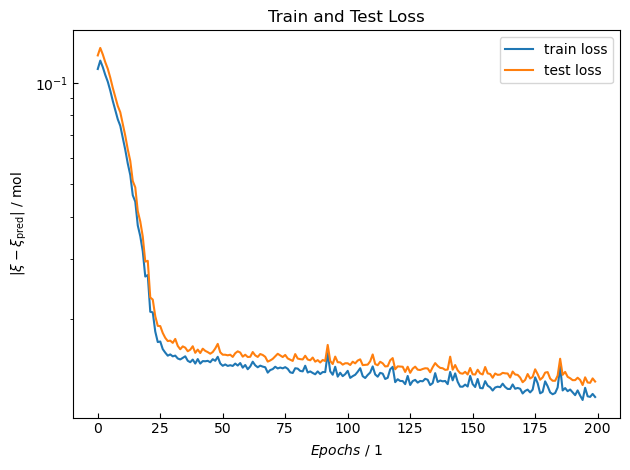

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

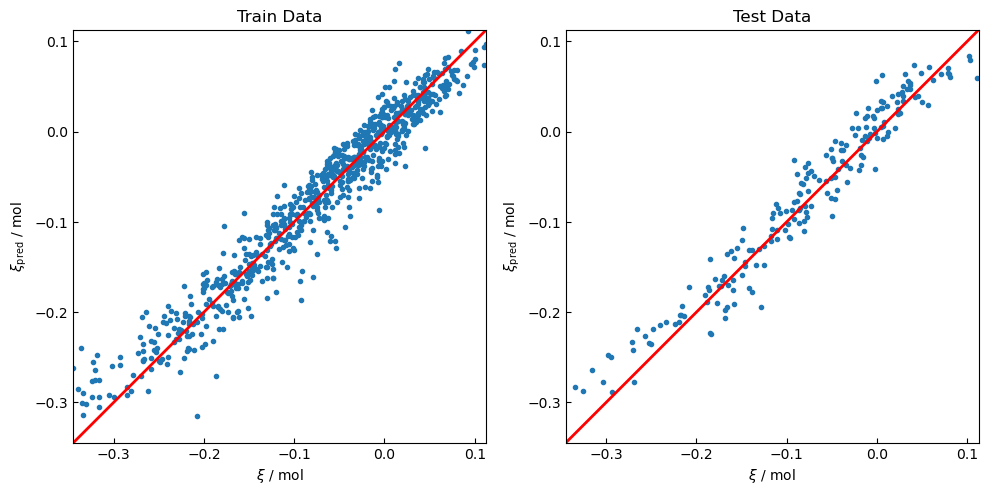

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

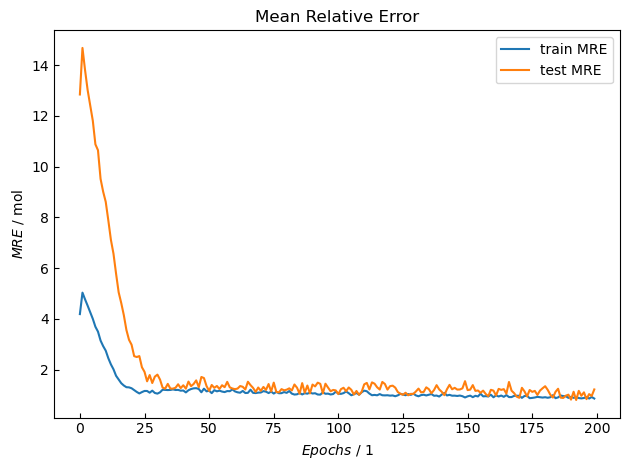

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

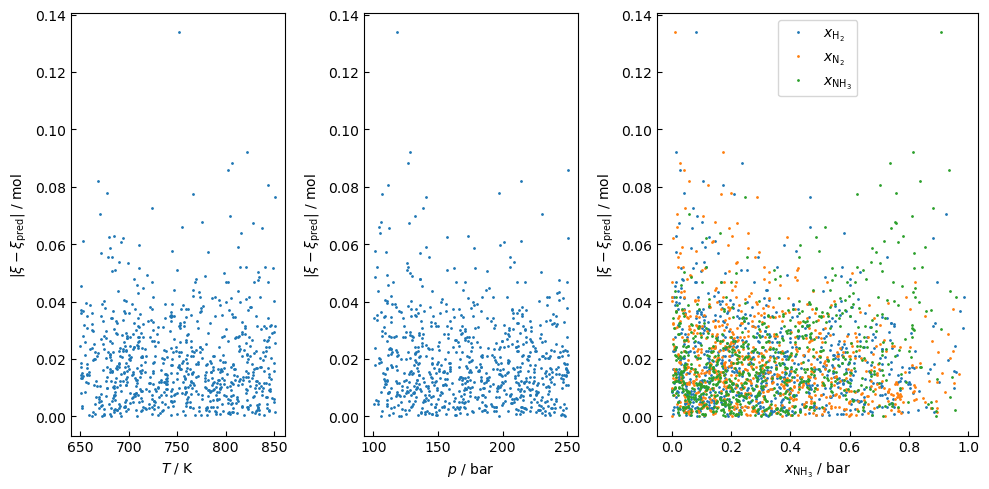

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

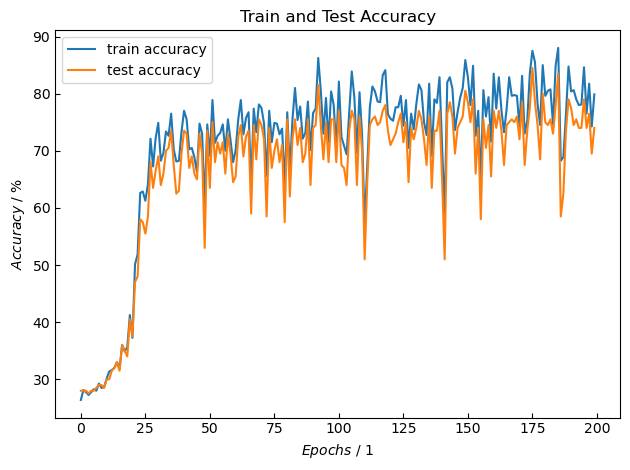

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[6.9462e+02, 1.0927e+02, 3.2873e-01, 8.8376e-02, 5.8289e-01],
        [7.0146e+02, 2.3552e+02, 7.0393e-01, 2.6491e-01, 3.1161e-02],
        [7.6055e+02, 1.8399e+02, 5.4327e-01, 4.0225e-01, 5.4476e-02],
        [7.5730e+02, 1.1356e+02, 1.2325e-01, 4.2649e-01, 4.5026e-01],
        [7.3639e+02, 1.1215e+02, 3.4737e-02, 4.2608e-01, 5.3919e-01],
        [8.0498e+02, 2.2130e+02, 7.6967e-01, 1.1676e-01, 1.1357e-01],
        [6.9767e+02, 2.2665e+02, 4.9035e-01, 3.1708e-01, 1.9257e-01],
        [7.9338e+02, 2.4362e+02, 1.9469e-01, 7.7407e-02, 7.2790e-01],
        [6.9023e+02, 2.3948e+02, 1.1377e-01, 8.5668e-02, 8.0056e-01],
        [7.4359e+02, 1.2095e+02, 9.8929e-02, 3.9438e-01, 5.0669e-01],
        [6.8435e+02, 1.8569e+02, 2.9204e-03, 4.0842e-02, 9.5624e-01],
        [7.9241e+02, 1.3365e+02, 2.6424e-01, 4.2288e-01, 3.1288e-01],
        [7.4978e+02, 2.4688e+02, 6.2549e-02, 3.7928e-01, 5.5817e-01],
        [8.3639e+02, 1.9007e+02, 3.1456e-01, 3.7625e-01, 3.0920e-01],
        [7.3840e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([1.0001, 0.9974, 0.9998, 0.9999, 1.0004], requires_grad=True),
 Parameter containing:
 tensor([7.1988e-05, 1.2032e-03, 5.5888e-04, 1.3014e-03, 6.1812e-04],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.4020,  0.2400, -0.3356, -0.4390, -0.0167],
         [-0.3734,  0.1339, -0.1223, -0.0068, -0.2716],
         [ 0.2856, -0.4429, -0.3483, -0.4457, -0.4197],
         [-0.1963,  0.4110,  0.2031, -0.3695,  0.2502],
         [ 0.2807,  0.1854, -0.4415,  0.4184, -0.1104],
         [ 0.3646,  0.3997, -0.2769,  0.0019,  0.1158],
         [-0.3918, -0.1388, -0.1414, -0.1579, -0.2227],
         [ 0.3415,  0.2845, -0.1106,  0.3789, -0.3519],
         [-0.3608, -0.1754,  0.3309,  0.1561,  0.2453],
         [-0.3501,  0.2790,  0.0852, -0.4476,  0.3261],
         [-0.3175, -0.4454, -0.2875,  0.4192, -0.1704],
         [ 0.3055, -0.4276, -0.3936, -0.3594, -0.1206],
         [ 0.2168, -0.4411, -0.0710,  0.1021, -0.1549],
         [-0.3457,  0.1222, -0.05

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1624, 0.2632, 0.9977, 0.1040, 0.0535],
        [0.3147, 0.9434, 0.0446, 0.7277, 0.0844]])
tensor([[ 0.0440],
        [-0.1800]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.4743e+02, 2.1317e+02, 1.0432e-01, 4.9683e-01, 3.9884e-01],
        [6.7977e+02, 1.5663e+02, 1.2510e-01, 3.8871e-01, 4.8619e-01],
        [7.5289e+02, 2.1155e+02, 2.5790e-01, 4.3035e-01, 3.1174e-01],
        [7.7966e+02, 2.5028e+02, 2.2024e-01, 3.3121e-01, 4.4855e-01],
        [6.8322e+02, 1.7510e+02, 9.4181e-02, 1.6315e-01, 7.4267e-01],
        [8.2527e+02, 2.2769e+02, 4.7819e-01, 3.3074e-01, 1.9107e-01],
        [6.9159e+02, 2.4126e+02, 3.0676e-01, 9.5072e-03, 6.8373e-01],
        [7.7372e+02, 2.0126e+02, 1.2444e-02, 8.0541e-01, 1.8215e-01],
        [6.5516e+02, 1.3160e+02, 4.5971e-01, 8.8985e-02, 4.5130e-01],
        [6.9962e+02, 1.2606e+02, 8.1565e-02, 2.1586e-01, 7.0257e-01],
        [7.6973e+02, 1.3614e+02, 6.0239e-01, 4.9534e-02, 3.4807e-01],
        [8.4548e+02, 1.4871e+02, 5.3645e-01, 8.3505e-02, 3.8005e-01],
        [6.7671e+02, 2.0588e+02, 4.0774e-01, 5.3315e-01, 5.9102e-02],
        [6.8195e+02, 1.9374e+02, 9.3211e-01, 5.2748e-02, 1.5141e-02],
        [8.2238e+02,